# Classifying emotions: a short walkthrough

In [1]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from util import plot_embedding, plot_confusion_matrix, show_heatmap

Load the dataset: 17 action units per face, with their labels

In [2]:
emotions=["fear 😱","happiness 😀","anger 😠","surprise 😮","sadness 😓","disgust 😜"]

csv = genfromtxt('emotions_action_units_training.csv', delimiter=',', skip_header=1)
training = csv[:,1:-1]
categories = csv[:,0]

csv = genfromtxt('emotions_action_units_test.csv', delimiter=',', skip_header=1)

testing = csv[:,1:-1]
testing_categories = csv[:,0]

First, let's use a simple kNN on our raw data (experimenting with different values for `k`, from 1 to 9):

In [3]:
from sklearn import neighbors

for k in range(1,10):

    clf = neighbors.KNeighborsClassifier(k)
    clf.fit(training, categories)

    predictions = clf.predict(testing)
    
    correct_prediction = 0
    for i in range(len(predictions)):
        if int(predictions[i]) == int(testing_categories[i]):
            correct_prediction += 1
    print("kNearestNeighbours, k=%d: %.1f%% successful prediction out of %d test faces" % (k, correct_prediction * 100./len(predictions), len(predictions)))

kNearestNeighbours, k=1: 46.9% successful prediction out of 258 test faces
kNearestNeighbours, k=2: 42.2% successful prediction out of 258 test faces
kNearestNeighbours, k=3: 50.8% successful prediction out of 258 test faces
kNearestNeighbours, k=4: 50.8% successful prediction out of 258 test faces
kNearestNeighbours, k=5: 50.0% successful prediction out of 258 test faces
kNearestNeighbours, k=6: 46.1% successful prediction out of 258 test faces
kNearestNeighbours, k=7: 49.6% successful prediction out of 258 test faces
kNearestNeighbours, k=8: 51.2% successful prediction out of 258 test faces
kNearestNeighbours, k=9: 52.3% successful prediction out of 258 test faces


In [4]:
from sklearn.metrics import classification_report

print(classification_report(testing_categories, predictions, target_names = emotions))

              precision    recall  f1-score   support

      fear 😱       0.25      0.47      0.33        19
 happiness 😀       0.82      0.78      0.80        72
     anger 😠       0.37      0.33      0.35        33
  surprise 😮       0.47      0.46      0.46        35
   sadness 😓       0.45      0.57      0.50        49
   disgust 😜       0.54      0.30      0.38        50

    accuracy                           0.52       258
   macro avg       0.48      0.49      0.47       258
weighted avg       0.55      0.52      0.53       258



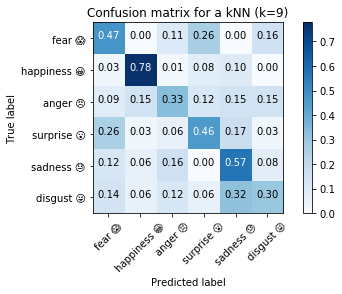

In [5]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(testing_categories, predictions)
plot_confusion_matrix(cnf_matrix, classes=emotions, normalize=True, title='Confusion matrix for a kNN (k=9)')

What if we first run a PCA and use the first principal components as input to the kNN, instead of the raw action units?

Let's first compute the PCA and look at how good it is at maximising the variance (eg, separating our emotions):

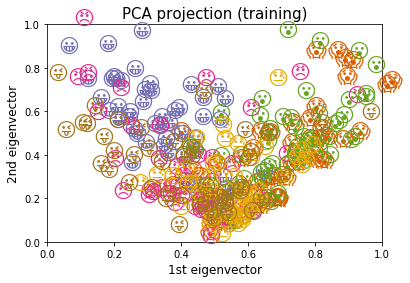

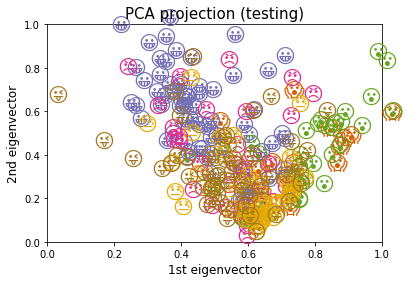

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(training)

training_pca = pca.transform(training)
testing_pca = pca.transform(testing)

plot_embedding(training_pca, categories,
               "PCA projection (training)",
               xlabel="1st eigenvector", ylabel="2nd eigenvector")


plot_embedding(testing_pca, testing_categories,
               "PCA projection (testing)",
               xlabel="1st eigenvector", ylabel="2nd eigenvector")

This embedding look somewhat promising: some emotions (eg *happiness*, *surpise*) seem nicely separated. Less so for *sadness*, *fear* and *anger*...

What action units contribute most to each eigen vector?

In [7]:
source_eigenvectors = {"ev1" : pca.inverse_transform([1,0,0,0,0]),
                       "ev2" : pca.inverse_transform([0,1,0,0,0]),
                       "ev3" : pca.inverse_transform([0,0,1,0,0]),
                       "ev4" : pca.inverse_transform([0,0,0,1,0]),
                       "ev5" : pca.inverse_transform([0,0,0,0,1])}

au_keys = ["AU01","AU02","AU04","AU05","AU06","AU07","AU09","AU10","AU12","AU14","AU15","AU17","AU20","AU23","AU25","AU26","AU45"]


import pandas as pd
df = pd.DataFrame(source_eigenvectors, index = au_keys)
show_heatmap(df)


,ev1,ev2,ev3,ev4,ev5
AU01,1.404505,1.429072,1.484164,1.472076,0.973107
AU02,0.718466,0.709582,0.572232,0.409497,0.575660
AU04,0.426691,0.503844,1.115054,0.557234,0.147934
AU05,1.549415,1.341790,1.064732,0.479943,1.270954
AU06,0.282470,0.878390,0.583626,0.614406,0.763206
AU07,0.378903,1.100275,1.072402,0.572900,0.575724
AU09,0.233682,0.621667,0.781736,0.082005,0.768972
AU10,0.571418,1.156876,0.817793,0.987008,1.013135
AU12,0.295146,0.746785,0.156414,0.689562,0.659142
AU14,0.276919,0.691202,0.377110,0.650648,0.701633


How does our kNN perform in the eigenspace?

In [8]:
clf = neighbors.KNeighborsClassifier(9)
clf.fit(training_pca, categories)


predictions = clf.predict(testing_pca)
print(classification_report(testing_categories, predictions, target_names = emotions))

              precision    recall  f1-score   support

      fear 😱       0.20      0.42      0.27        19
 happiness 😀       0.72      0.74      0.73        72
     anger 😠       0.34      0.36      0.35        33
  surprise 😮       0.44      0.31      0.37        35
   sadness 😓       0.45      0.55      0.50        49
   disgust 😜       0.46      0.22      0.30        50

    accuracy                           0.47       258
   macro avg       0.43      0.43      0.42       258
weighted avg       0.49      0.47      0.47       258



Not better!! Why? possible explanation: the dataset is now compressed, from 17 dimensions down to 5. Even though these dimensions encode more information than the original ones, we've nevertheless lost some information.

Instead of PCA, let's experiment with **Linear Discriminant Analysis** (LDA): similar to PCA, but acount for classes: instead of trying to maximise the variance *globally* in the dataset (PCA), the LDA tries to maximise the variance *between* classes (eg, between emotions), and *minimize* the variance within classes (eg the faces of a same emotions should be 'closer' to each other).

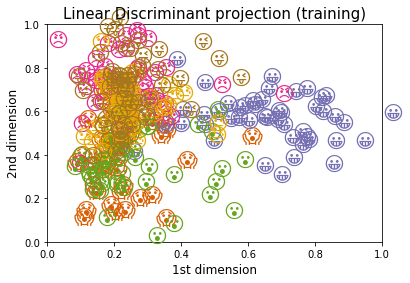

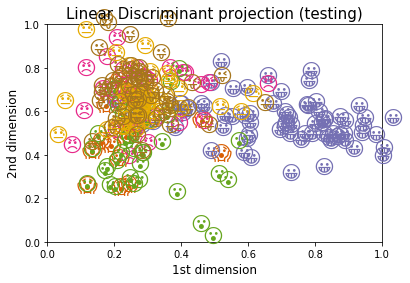

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


lda = LinearDiscriminantAnalysis(n_components=5)
lda.fit(training, categories)

training_lda = lda.transform(training)
testing_lda = lda.transform(testing)

plot_embedding(training_lda, categories,
               "Linear Discriminant projection (training)",
               xlabel="1st dimension", ylabel="2nd dimension")


plot_embedding(testing_lda, testing_categories,
               "Linear Discriminant projection (testing)",
               xlabel="1st dimension", ylabel="2nd dimension")

In [10]:
clf = neighbors.KNeighborsClassifier(9)
clf.fit(training_lda, categories)


predictions = clf.predict(testing_lda)
print(classification_report(testing_categories, predictions, target_names = emotions))

              precision    recall  f1-score   support

      fear 😱       0.17      0.21      0.19        19
 happiness 😀       0.89      0.79      0.84        72
     anger 😠       0.33      0.48      0.39        33
  surprise 😮       0.48      0.60      0.53        35
   sadness 😓       0.51      0.57      0.54        49
   disgust 😜       0.39      0.18      0.25        50

    accuracy                           0.52       258
   macro avg       0.46      0.47      0.46       258
weighted avg       0.54      0.52      0.52       258



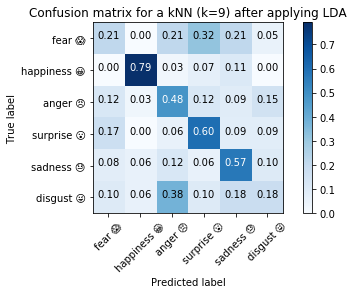

In [11]:
cnf_matrix = confusion_matrix(testing_categories, predictions)
plot_confusion_matrix(cnf_matrix, classes=emotions, normalize=True, title='Confusion matrix for a kNN (k=9) after applying LDA')

## SVM

Let's try the same classification, using a SVM. We will start with the raw 17 action units, and then try with features resulting from applying LDA.

In [12]:
from sklearn import svm

C=1.0
gamma=0.7
degree=4

for kernel in ['linear','poly','rbf']:

    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree)
    clf.fit(training, categories)


    predictions = clf.predict(testing)
    correct_prediction = 0
    for i in range(len(predictions)):
        if int(predictions[i]) == int(testing_categories[i]):
            correct_prediction += 1
    print("\n#### SVM, kernel: %s\n\n %.1f%% successful prediction out of %d test faces\n" % (kernel, correct_prediction * 100./len(predictions), len(predictions)))
    print(classification_report(testing_categories, predictions, target_names = emotions))


#### SVM, kernel: linear

 52.3% successful prediction out of 258 test faces

              precision    recall  f1-score   support

      fear 😱       0.19      0.32      0.24        19
 happiness 😀       0.90      0.75      0.82        72
     anger 😠       0.38      0.45      0.42        33
  surprise 😮       0.51      0.54      0.53        35
   sadness 😓       0.44      0.55      0.49        49
   disgust 😜       0.50      0.28      0.36        50

    accuracy                           0.52       258
   macro avg       0.49      0.48      0.47       258
weighted avg       0.56      0.52      0.53       258


#### SVM, kernel: poly

 38.0% successful prediction out of 258 test faces

              precision    recall  f1-score   support

      fear 😱       0.11      0.42      0.18        19
 happiness 😀       0.86      0.43      0.57        72
     anger 😠       0.31      0.30      0.31        33
  surprise 😮       0.55      0.34      0.42        35
   sadness 😓       0.43      0

Same with the result of a LDA:

In [13]:
for kernel in ['linear','poly','rbf']:

    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree)
    clf.fit(training_lda, categories)


    predictions = clf.predict(testing_lda)
    print("\n#### SVM + LDA, kernel: %s\n" % kernel)
    print(classification_report(testing_categories, predictions, target_names = emotions))


#### SVM + LDA, kernel: linear

              precision    recall  f1-score   support

      fear 😱       0.18      0.16      0.17        19
 happiness 😀       0.86      0.76      0.81        72
     anger 😠       0.37      0.42      0.39        33
  surprise 😮       0.48      0.57      0.52        35
   sadness 😓       0.44      0.57      0.50        49
   disgust 😜       0.42      0.28      0.34        50

    accuracy                           0.52       258
   macro avg       0.46      0.46      0.45       258
weighted avg       0.53      0.52      0.52       258


#### SVM + LDA, kernel: poly

              precision    recall  f1-score   support

      fear 😱       0.14      0.26      0.19        19
 happiness 😀       0.64      0.58      0.61        72
     anger 😠       0.26      0.27      0.26        33
  surprise 😮       0.46      0.34      0.39        35
   sadness 😓       0.41      0.57      0.48        49
   disgust 😜       0.29      0.16      0.21        50

    accuracy 

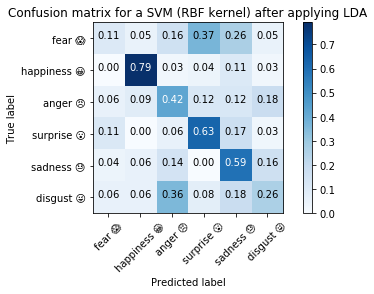

In [14]:
cnf_matrix = confusion_matrix(testing_categories, predictions)
plot_confusion_matrix(cnf_matrix, classes=emotions, normalize=True, title='Confusion matrix for a SVM (RBF kernel) after applying LDA')

### MLP

Lastly, let's train a multi-layer perceptron to classify our dataset:

In [19]:
from sklearn.neural_network import MLPClassifier

for layers in [(20,), (20,20,), (100,), (100,100)]:

    clf = MLPClassifier(hidden_layer_sizes=layers, random_state=1, max_iter=500)
    clf.fit(training, categories)


    predictions = clf.predict(testing)
    print("\n#### MLP, hidden layers: %s\n" % str(layers))
    print(classification_report(testing_categories, predictions, target_names = emotions))

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



#### MLP, hidden layers: (20,)

              precision    recall  f1-score   support

      fear 😱       0.26      0.42      0.32        19
 happiness 😀       0.86      0.71      0.78        72
     anger 😠       0.40      0.52      0.45        33
  surprise 😮       0.38      0.31      0.34        35
   sadness 😓       0.47      0.57      0.51        49
   disgust 😜       0.53      0.38      0.44        50

    accuracy                           0.52       258
   macro avg       0.48      0.49      0.47       258
weighted avg       0.55      0.52      0.53       258



/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



#### MLP, hidden layers: (20, 20)

              precision    recall  f1-score   support

      fear 😱       0.22      0.32      0.26        19
 happiness 😀       0.87      0.75      0.81        72
     anger 😠       0.30      0.36      0.33        33
  surprise 😮       0.44      0.46      0.45        35
   sadness 😓       0.49      0.53      0.51        49
   disgust 😜       0.45      0.36      0.40        50

    accuracy                           0.51       258
   macro avg       0.46      0.46      0.46       258
weighted avg       0.54      0.51      0.52       258



/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



#### MLP, hidden layers: (100,)

              precision    recall  f1-score   support

      fear 😱       0.19      0.32      0.24        19
 happiness 😀       0.84      0.79      0.81        72
     anger 😠       0.44      0.45      0.45        33
  surprise 😮       0.46      0.46      0.46        35
   sadness 😓       0.52      0.55      0.53        49
   disgust 😜       0.49      0.36      0.41        50

    accuracy                           0.54       258
   macro avg       0.49      0.49      0.48       258
weighted avg       0.56      0.54      0.55       258


#### MLP, hidden layers: (100, 100)

              precision    recall  f1-score   support

      fear 😱       0.29      0.63      0.40        19
 happiness 😀       0.88      0.81      0.84        72
     anger 😠       0.29      0.36      0.32        33
  surprise 😮       0.48      0.40      0.44        35
   sadness 😓       0.52      0.55      0.53        49
   disgust 😜       0.50      0.28      0.36        50

    a

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


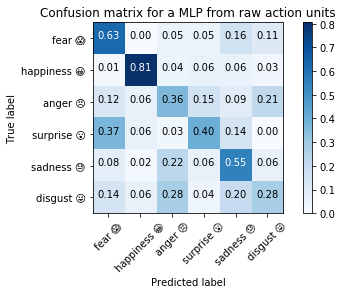

In [20]:
cnf_matrix = confusion_matrix(testing_categories, predictions)
plot_confusion_matrix(cnf_matrix, classes=emotions, normalize=True, title='Confusion matrix for a MLP from raw action units')

After applying LDA:

In [21]:
from sklearn.neural_network import MLPClassifier

for layers in [(20,), (100,), (100,100), (20,20,)]:

    clf = MLPClassifier(hidden_layer_sizes=layers, random_state=1, max_iter=500)
    clf.fit(training_lda, categories)


    predictions = clf.predict(testing_lda)
    print("\n#### MLP + LDA, hidden layers: %s\n" % str(layers))
    print(classification_report(testing_categories, predictions, target_names = emotions))

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



#### MLP + LDA, hidden layers: (20,)

              precision    recall  f1-score   support

      fear 😱       0.10      0.05      0.07        19
 happiness 😀       0.84      0.79      0.81        72
     anger 😠       0.36      0.42      0.39        33
  surprise 😮       0.50      0.63      0.56        35
   sadness 😓       0.46      0.55      0.50        49
   disgust 😜       0.53      0.40      0.45        50

    accuracy                           0.55       258
   macro avg       0.46      0.47      0.46       258
weighted avg       0.54      0.55      0.54       258



/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



#### MLP + LDA, hidden layers: (100,)

              precision    recall  f1-score   support

      fear 😱       0.18      0.16      0.17        19
 happiness 😀       0.84      0.75      0.79        72
     anger 😠       0.35      0.42      0.38        33
  surprise 😮       0.55      0.60      0.58        35
   sadness 😓       0.47      0.55      0.51        49
   disgust 😜       0.45      0.38      0.41        50

    accuracy                           0.53       258
   macro avg       0.47      0.48      0.47       258
weighted avg       0.55      0.53      0.54       258



/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



#### MLP + LDA, hidden layers: (100, 100)

              precision    recall  f1-score   support

      fear 😱       0.22      0.32      0.26        19
 happiness 😀       0.79      0.75      0.77        72
     anger 😠       0.30      0.39      0.34        33
  surprise 😮       0.55      0.46      0.50        35
   sadness 😓       0.47      0.37      0.41        49
   disgust 😜       0.38      0.40      0.39        50

    accuracy                           0.49       258
   macro avg       0.45      0.45      0.45       258
weighted avg       0.52      0.49      0.50       258


#### MLP + LDA, hidden layers: (20, 20)

              precision    recall  f1-score   support

      fear 😱       0.26      0.26      0.26        19
 happiness 😀       0.83      0.76      0.80        72
     anger 😠       0.38      0.45      0.41        33
  surprise 😮       0.60      0.60      0.60        35
   sadness 😓       0.47      0.55      0.50        49
   disgust 😜       0.53      0.42      0.47   

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


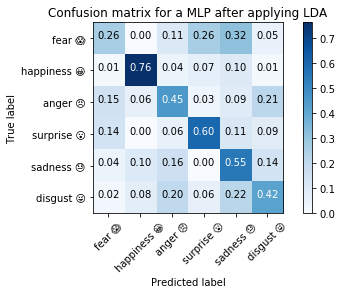

In [23]:
cnf_matrix = confusion_matrix(testing_categories, predictions)
plot_confusion_matrix(cnf_matrix, classes=emotions, normalize=True, title='Confusion matrix for a MLP after applying LDA')

We observe that, while LDA increases overall accuracy (56% from 52%), some emotions (like *fear*) are much more often misclassified (recall = 26%, down from 63% without LDA).